# Assignment 3

### Importing Libraries

In [21]:
import cv2
import numpy as np
import time
import math as m
import random
from google.colab.patches import cv2_imshow

### Gaussian function for getting gaussian values for a particular point (x,y)

In [22]:
## taken from prev assignment

def evaluator(x, y, sigma):
    return (1/(2 * (m.pi) * ((sigma) ** 2))*(1/(m.exp(((x**2) + (y**2))/(2 * (sigma ** 2))))))

### Function to get gaussian filter

In [23]:
## taken from prev assignment

def gauss_filter(size, sigma):
    
    gs_filter = np.zeros((size,size))
    
    for x in range(size):
        for y in range(size):
            gs_filter[x,y] = evaluator(x - (size//2),y - (size//2),sigma)

    return gs_filter

### Function to apply filter to an image

In [24]:
## taken from prev assignment

def filter_the_img(image,filt,size):
    
    image_row,image_col = image.shape # rows and columns in our image
    res = np.zeros(image.shape) # we'll save results in this array
    
    val = size//2 # limit so that these values aren't affected in the output array
    
    for row in range(image_row):
        for col in range(image_col):
            if(row < val or row > image_row - val - 1 or col < val or col > image_col - val - 1):
                res[row,col] = image[row,col] # cant apply filter to these values
            else:
                res[row, col] = np.sum(filt * image[row-val:row+val+1, col-val:col+val+1])
    return res

### Function to get horizontally and vertically sobel filtered images


In [25]:
## taken from prev assignment

def sobel_v(image):
    y = np.array([[1, 0, -1],
                  [2, 0, -2],
                  [1, 0, -1]])
    res = filter_the_img(image,y,3)
    return res

def sobel_h(image):
    x = np.array([[1, 2, 1],
                  [0, 0, 0],
                  [-1, -2, -1]])
    res = filter_the_img(image,x,3)
    return res

### Function to get corner response function for harris corner detection

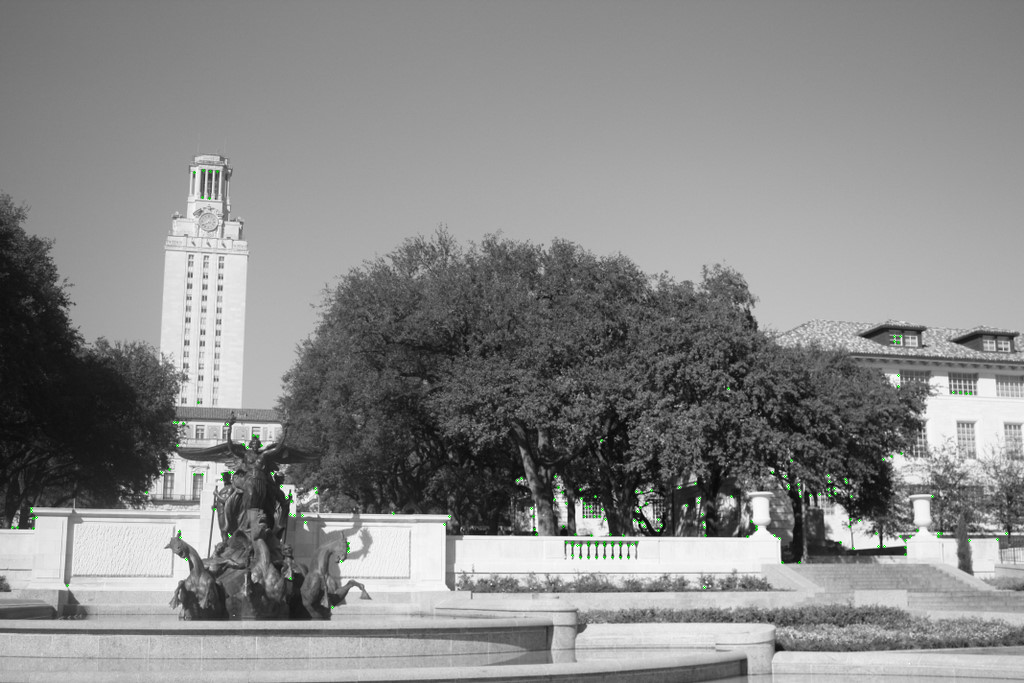

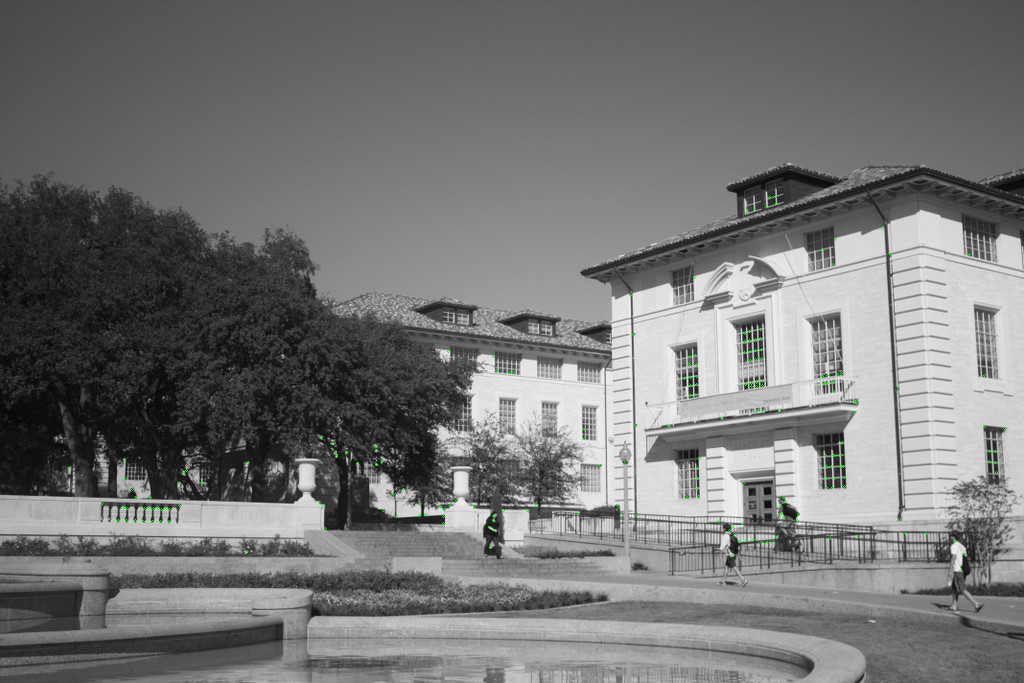

In [26]:
def crf_R(image, count):
    
    r,c = image.shape
    res = np.zeros((r,c)) #result array
    
    # applying sobel filters to the image
    I_x = sobel_h(image)
    I_y = sobel_v(image)
    
    # getting x^2, y^2, xy and yx
    I_x2 = np.square(I_x)
    I_y2 = np.square(I_y)
    I_xy = np.multiply(I_x,I_y)
    
    # applying gaussian filter to smooth obtained images
    I_x2 = filter_the_img(I_x2,gauss_filter(5,2.23),5)
    I_xy = filter_the_img(I_xy,gauss_filter(5,2.23),5)
    I_y2 = filter_the_img(I_y2,gauss_filter(5,2.23),5)
    
    #"Cornerness" Response function
    crf_R = np.zeros((r,c), np.float32)
    alpha = 0.05
    for x in range(r):
        for y in range(c):
            mom_matrix = np.array([[I_x2[x][y], I_xy[x][y]], [I_xy[x][y], I_y2[x][y]]])
            crf_R[x][y] = np.linalg.det(mom_matrix) - (alpha * np.square(I_x2[x][y] + I_y2[x][y]))
    
    thresh = 500000
    thickness = 1
    rad = 1

    points = []
    # Look for Corner strengths above the threshold
    for row in range(r):
        for column in range(c):
            if crf_R[row][column] > thresh:
                max = crf_R[row][column]

            # Local non-maxima suppression
                next = False
                for temprow in range(5):
                    for tempcolumn in range(5):
                        if row + temprow - 2 < r and column + tempcolumn - 2 < c:
                            if crf_R[temprow + row - 2][tempcolumn + column - 2] > max:
                                next = True
                                break

                if not next:
                    # Point is expressed in x, y which is col, row
                    points.append((max, column, row))
                    
    image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    points.sort(reverse = True)
    for x in range(min(len(points),200)):
      image = cv2.circle(image, (points[x][1], points[x][2]), rad, (0,255,0) , thickness)

    cv2_imshow(image)
    cv2.waitKey(0)
    if count == 0:
      outname = "left res " + str(thresh) + ".jpg"
    else:
      outname = "right res " + str(thresh) + ".jpg"
    cv2.imwrite(outname, image)
    return image, points[:min(len(points),200)]
                    
image_l = cv2.imread('uttower_left.jpg', cv2.IMREAD_GRAYSCALE)
image_r = cv2.imread('uttower_right.jpg', cv2.IMREAD_GRAYSCALE)
finl, finlp = crf_R(image_l, 0)
finr, finrp = crf_R(image_r, 1) 

###Combining both images side by side to find matching features

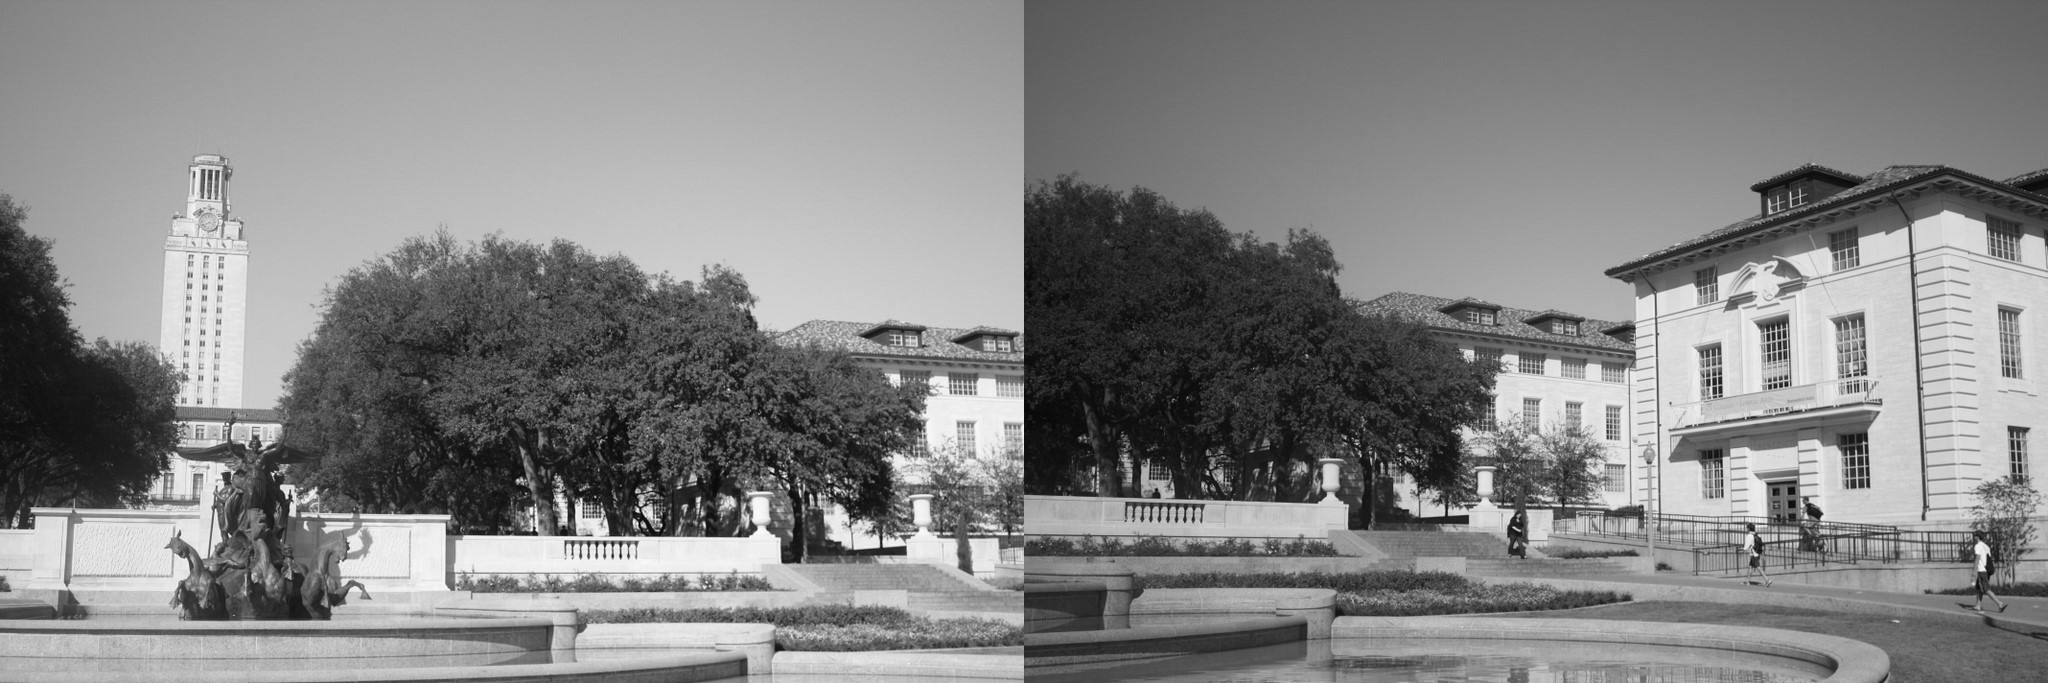

(683, 2048, 3)


In [27]:
from PIL import Image

### just a simple code to conact both images

im1 = Image.open('uttower_left.jpg')
im2 = Image.open('uttower_right.jpg')

def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst
  
combined = get_concat_h(im1,im2)
combined =  np.asarray(combined)
combined_gray = cv2.cvtColor(combined, cv2.COLOR_BGR2GRAY)
cv2_imshow(combined_gray)
print(combined.shape)

###Normalised Cross Correlation

In [33]:
import argparse
import numpy as np
import pylab as pl

### normalised cross correlation
def ncc(src, target):
    src = src - np.mean(src)
    target = target - np.mean(target)
    numerator = np.sum(src*target)
    denominator = np.sqrt(np.sum(target*target) * np.sum(src*src))

    return numerator / denominator
    

### function to see if the patches we selected actually match
def patch_matcher(img, target):
    height, width = img.shape
    tar_height, tar_width = target.shape
    (Y, X) = (0, 0)

    img = np.array(img, dtype="int")
    target = np.array(target, dtype="int")
 
    return (ncc(img,target), Y, X)


[((0.9916551383204557, 1420, 516), 853, 548), ((0.9899457869619989, 1467, 523), 905, 554), ((0.9877024862251256, 1168, 508), 572, 545), ((0.986853162479701, 1472, 351), 898, 375), ((0.9817673223020227, 1347, 505), 779, 538), ((0.9803566506640389, 1168, 508), 588, 545), ((0.9792198672405849, 1168, 508), 580, 545), ((0.9788595273008968, 1343, 502), 774, 535), ((0.9786864166951477, 1467, 516), 905, 547), ((0.977030295178762, 1190, 508), 577, 545), ((0.9767841365795509, 1168, 508), 620, 545), ((0.9749534810837939, 1349, 528), 782, 562), ((0.9738140869554802, 1168, 508), 596, 545), ((0.9719482999673009, 1168, 508), 612, 545), ((0.9716123094980571, 1427, 489), 859, 520), ((0.9714908179072347, 1407, 510), 840, 542), ((0.9680944331728863, 1168, 508), 628, 545), ((0.9675615638979943, 1271, 463), 699, 498), ((0.9655042550595409, 1168, 508), 604, 545), ((0.9608785442919683, 1150, 520), 580, 557), ((0.9608206183333902, 1150, 520), 604, 557), ((0.9604818616688483, 1150, 520), 596, 557), ((0.9594848

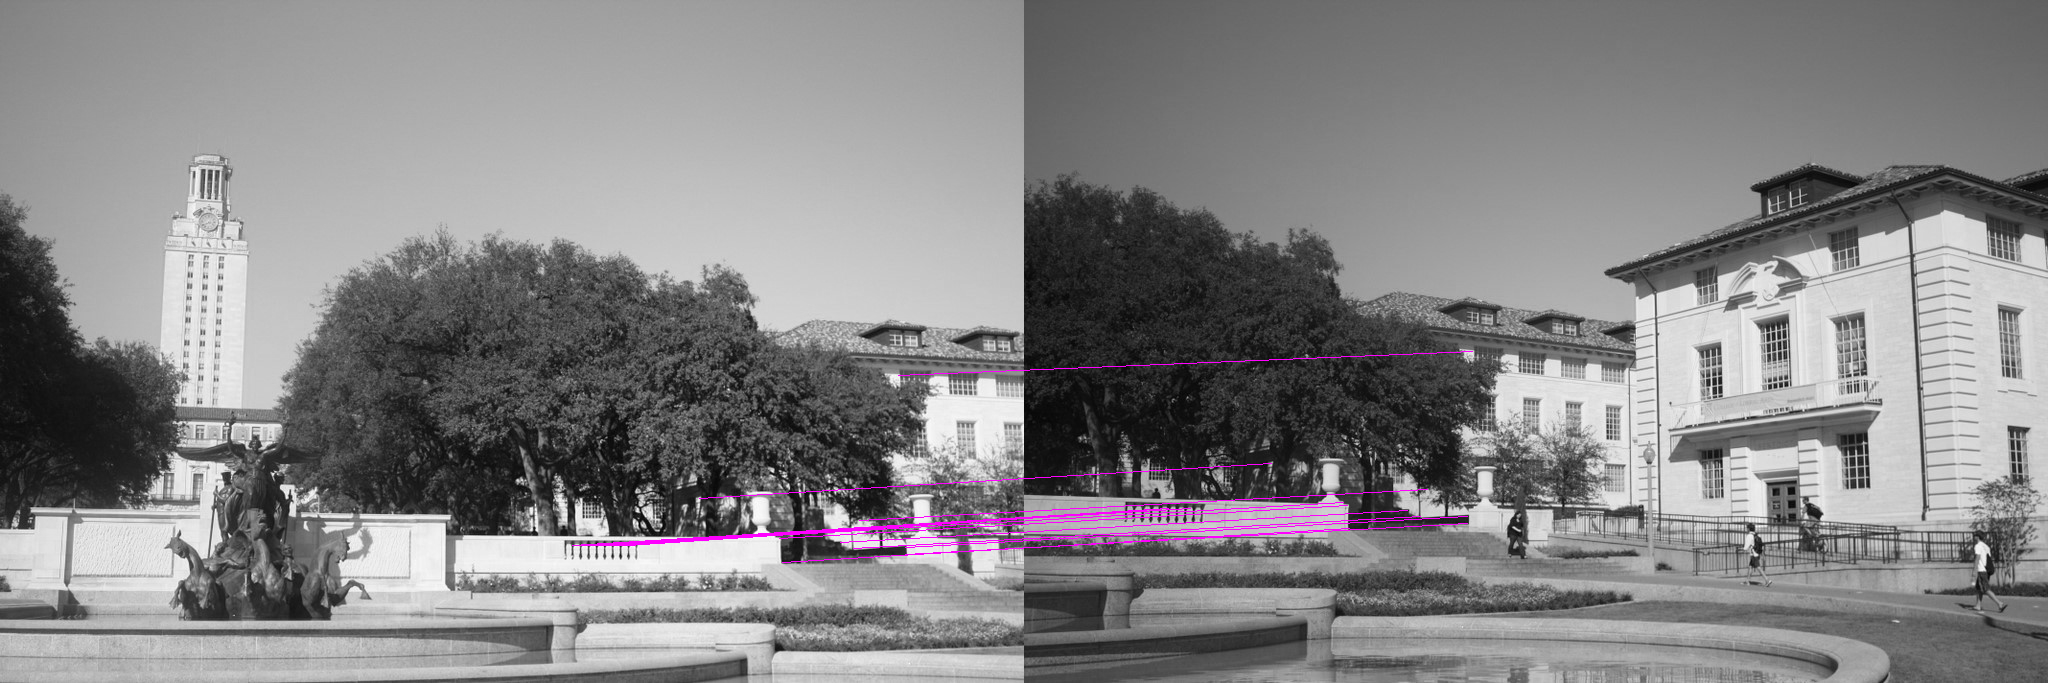

In [34]:
### main to find matching features

combined_gray22 = cv2.cvtColor(combined_gray,cv2.COLOR_GRAY2RGB)

features = []

for p in finlp:
  target = image_l[p[2]-4:p[2]+5,p[1]-4:p[1]+5]
  maxi = -1
  mx,my = 0,0
  # combined_gray22 = cv2.circle(combined_gray22, (p[1], p[2]), 1, (0,255,0) , 1)
  for p2 in finrp:
    matchwith = image_r[p2[2]-4:p2[2]+5,p2[1]-4:p2[1]+5]
    her = patch_matcher(matchwith,target)
    if her[0] > maxi:
      maxi = her[0]
      my = image_r.shape[1] + p2[1]
      mx = p2[2]
      
    # combined_gray22 = cv2.circle(combined_gray22, (my,mx), 1, (0,255,255), 1)

  features.append(((maxi,my,mx),p[1],p[2]))


features.sort(reverse = True)
print(features)


top20 = 0
combined_gray2 = cv2.cvtColor(combined_gray,cv2.COLOR_GRAY2RGB)
for mt in features:
  top20 += 1
  if top20 == 20:
    break
  cv2.line(combined_gray22, (mt[1],mt[2]), (mt[0][1], mt[0][2]), (255,0,255), 1)

cv2_imshow(combined_gray22)


In [35]:
cv2.imwrite("matched_features.jpg", combined_gray22)

True

In [36]:
### a1 and a2 as in question 2

features.sort(reverse=True)
a1 = features[:20]
random.shuffle(features)
a2 = features[:30]
print(a1)
print(a2)


[((0.9916551383204557, 1420, 516), 853, 548), ((0.9899457869619989, 1467, 523), 905, 554), ((0.9877024862251256, 1168, 508), 572, 545), ((0.986853162479701, 1472, 351), 898, 375), ((0.9817673223020227, 1347, 505), 779, 538), ((0.9803566506640389, 1168, 508), 588, 545), ((0.9792198672405849, 1168, 508), 580, 545), ((0.9788595273008968, 1343, 502), 774, 535), ((0.9786864166951477, 1467, 516), 905, 547), ((0.977030295178762, 1190, 508), 577, 545), ((0.9767841365795509, 1168, 508), 620, 545), ((0.9749534810837939, 1349, 528), 782, 562), ((0.9738140869554802, 1168, 508), 596, 545), ((0.9719482999673009, 1168, 508), 612, 545), ((0.9716123094980571, 1427, 489), 859, 520), ((0.9714908179072347, 1407, 510), 840, 542), ((0.9680944331728863, 1168, 508), 628, 545), ((0.9675615638979943, 1271, 463), 699, 498), ((0.9655042550595409, 1168, 508), 604, 545), ((0.9608785442919683, 1150, 520), 580, 557)]
[((0.9749534810837939, 1349, 528), 782, 562), ((0.8321229630154404, 1159, 497), 536, 534), ((0.728159

#A failed attempt to implement ransac

###Let me explain what I tried to implement first. Initially we take the matched features and then seperate the matched coordinates in left image and then right image. Initially I tried to just find the affine transformation directly. But I couldn't get a proper transformed image. Then I shifted the image to a position where the offset of matching features and minimum. Then I tried to find affine transformation matrix after shifted right image to left by that offset. For ransac I just take the matched features points and try to find an affine matrix which has the highest number of inliers. I feel that I am not being able to add depth to the image or maybe my affine transformation matrix procedure is wrong. I am not able to figure out my mistake though.

In [37]:


def ransac(features,num,img):
    
    #getting valid pixel points
    r,c = img.shape
    pts_l , pts_r = [],[]
    for x in features:
      pts_l.append((x[1],x[2]))
      pts_r.append((x[0][1],x[0][2]))

    min_os = features[0][0][1] - features[0][1]
    fin = 1e9
    for x in features:
      temp_os = x[0][1] - x[1]
      total_dist = 0
      for y in features:
        total_dist += m.sqrt(abs(y[0][1] - y[1] - temp_os)**2 + abs(y[0][2] - y[2])**2)

      if(total_dist < fin):
        min_os = temp_os
        fin = total_dist

    print(min_os)
    thresh = 4600000
    inlierpoints = []
    final_A = None
    print(len(pts_l))
    maxinliers = 0
    temp = 0
    while(temp < num):
      temp += 1
      A = 2*np.random.rand(4,2) - 1
      diff = 0
      inliers = 0
      for x in range(len(features)):
        offset = (0,min_os)
        for pt in range(len(pts_l)):
          temp2 = np.asarray((pts_r[pt][1],pts_r[pt][0]))
          tem2 = temp2 - np.asarray(offset)
          trans = np.dot(np.asarray(A),temp2)
          curr_diff = abs(float(pts_l[pt][1]) - trans[0])**2 + abs(float(pts_l[pt][0]) -
                                                              (trans[1]))**2
          # print(float(pts_l[pt][1]))
          # print(trans[1])
          # print(curr_diff)
          if m.sqrt(curr_diff) < 10:
            inliers += 1

        if(inliers > maxinliers):
          final_A = A
          maxinliers = inliers
        
        break

    c = min_os 
    return final_A,maxinliers,c


In [38]:
a,b,c = ransac(a1,50000,combined_gray)
print(a)
print(b)
print(combined_gray.shape)
# print(a)
# print(b)

569
20
[[ 0.05747282  0.36751386]
 [-0.86482156  0.91653247]
 [ 0.29270354  0.16043108]
 [-0.61653442 -0.9142782 ]]
2
(683, 2048)


In [39]:
print(c)

569


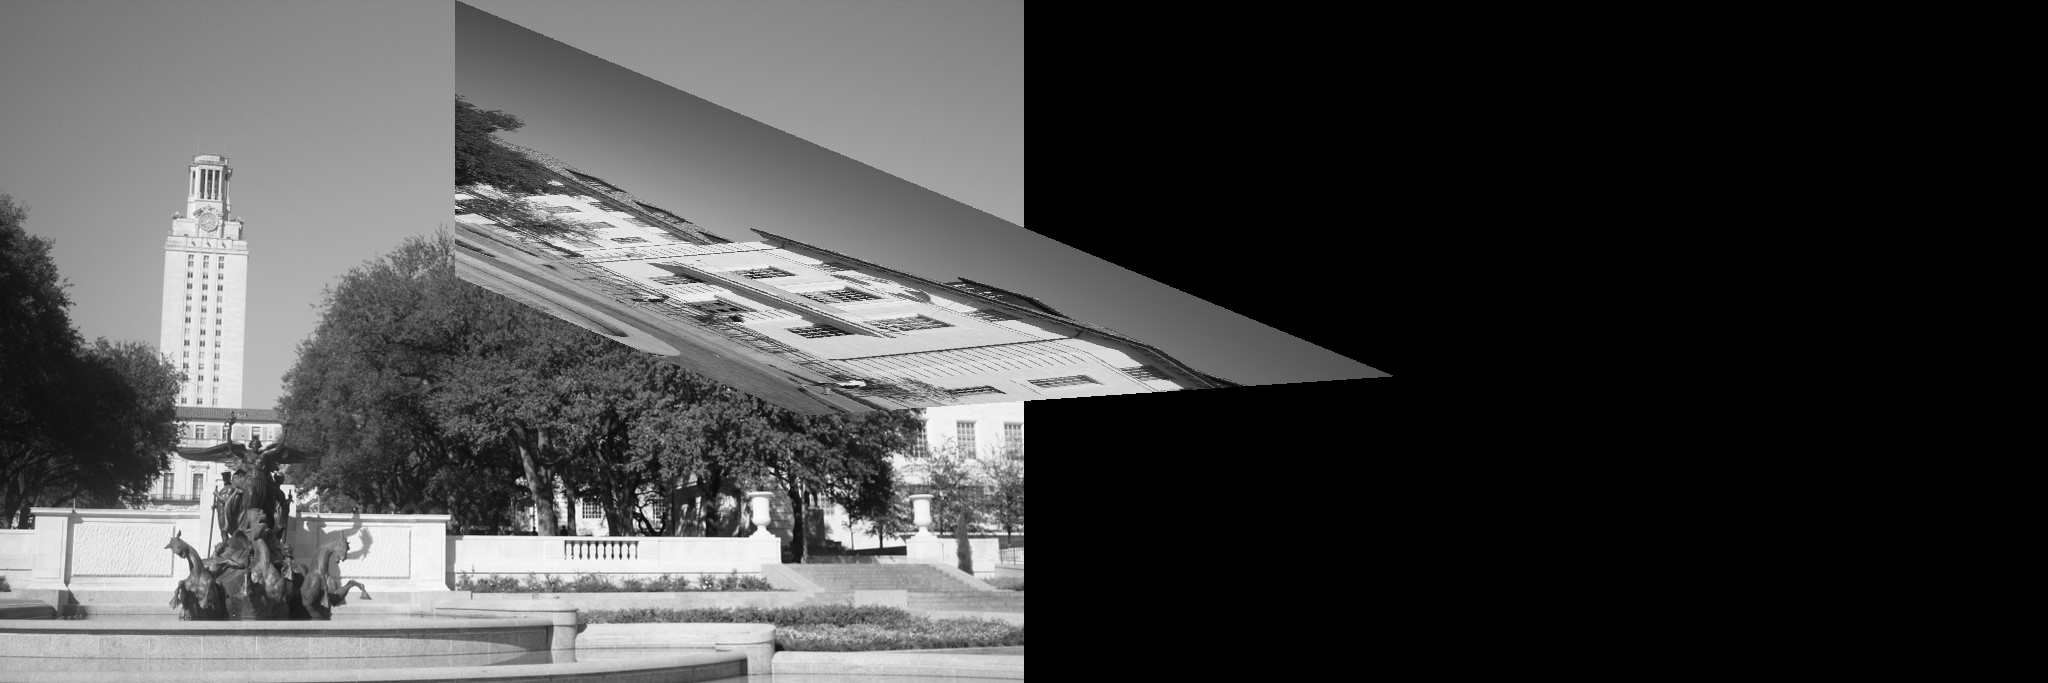

In [40]:
new_image = np.zeros(combined_gray.shape)
temp_image = np.zeros((2000,4000))
os = c
prep = a
  
for c in range(image_l.shape[0]):
  for r in range(image_l.shape[1]):
    new_image[c][r] = image_l[c][r]


for c in range(image_l.shape[0]):
  for r in range(image_l.shape[1]):
    curr = (c,r)
    # new_image[c][r+image_l.shape[1]-os] = image_r[c][r]
    
    new = np.dot(np.asarray(prep),np.asarray(curr))
    new = new
    new = new.astype(np.int64)
    # print(type(new[0]))
    if(new[0]>=0 and new[0]<new_image.shape[0] and new[1]>=0 and new[1]+image_l.shape[1]-os<new_image.shape[1]):
      new_image[new[0]][new[1]+image_l.shape[1]-os] = image_r[c][r]

# for x in a1:
#   cv2.line(new_image, (x[1]+image_l.shape[1]-os,x[2]), (x[0][1], x[0][2]), (255,0,255), 1)
# for c in range(image_r.shape[0]):
#   for r in range(image_r.shape[1]):
#     trans = np.dot(np.asarray(a),np.asarray((c+os,r)))
#     trans[0] = int(trans[0])
#     trans[1] = int(trans[1])
#     # print(trans) 
#     if(trans[0]>=0 and trans[1]>=0 and trans[0]<new_image.shape[0] and trans[1]<new_image.shape[1]):
#       new_image[int(trans[0])][int(trans[1])] = image_r[c][r]

cv2_imshow(new_image)

###Detecting features and stitching images using inbuilt functions

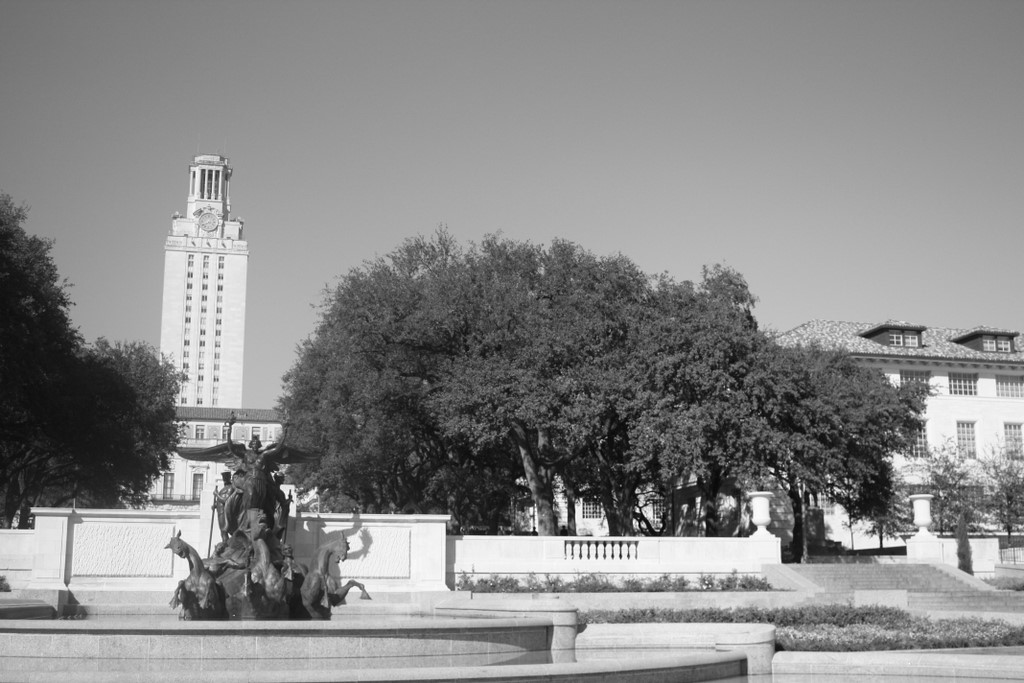

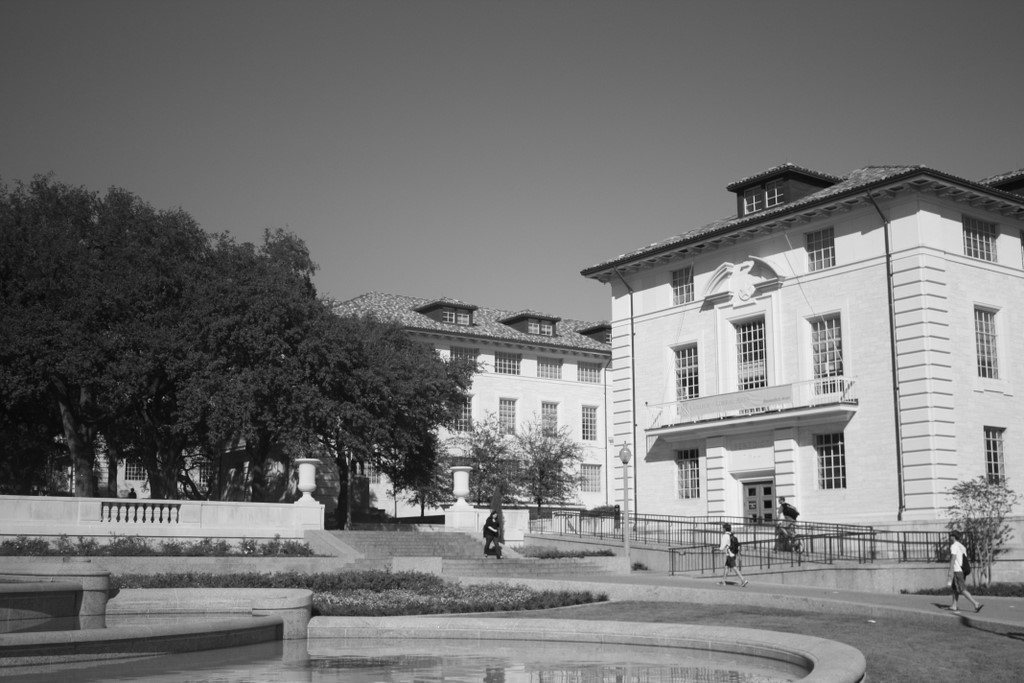

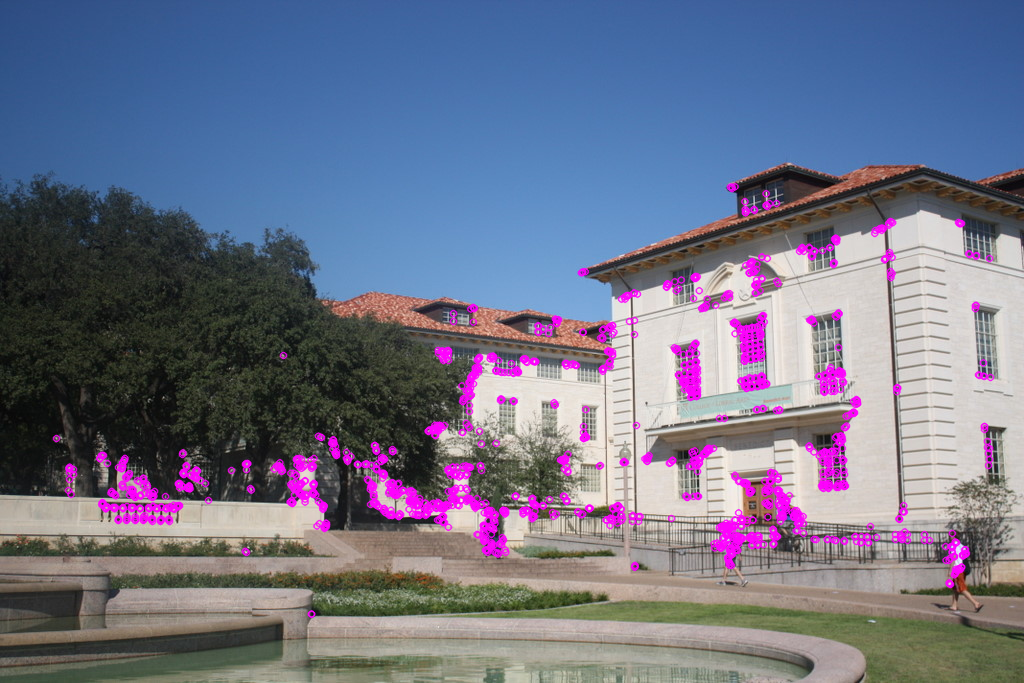

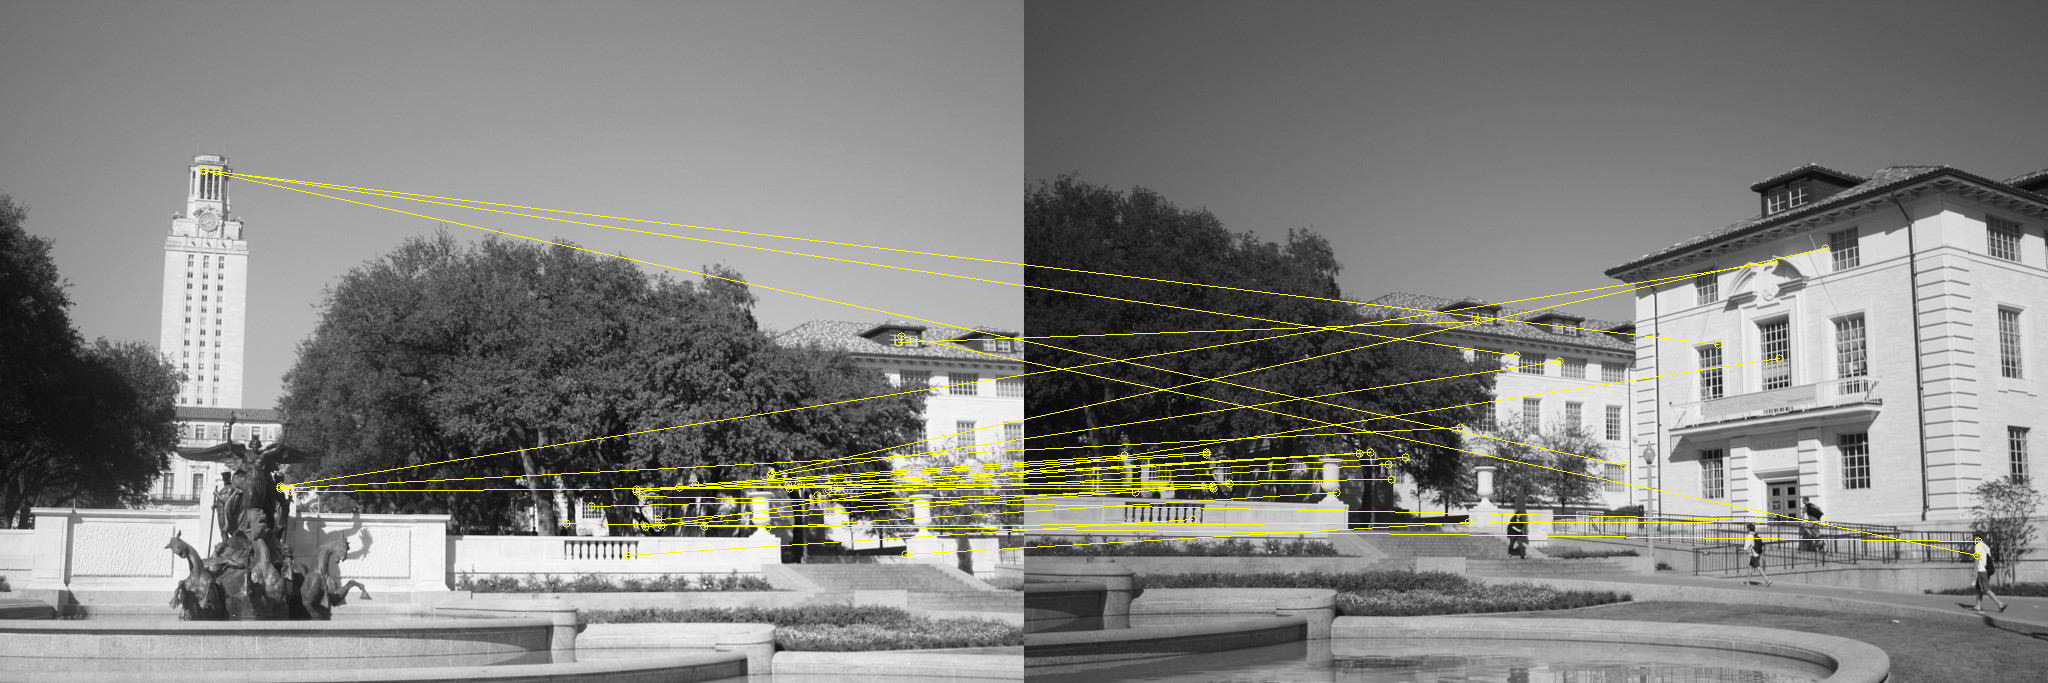

[[ 1.34121655e+00 -6.26483032e-02 -6.00780564e+02]
 [ 1.84796620e-01  1.26406079e+00 -1.85633500e+02]
 [ 3.09143310e-04  4.49146089e-05  1.00000000e+00]]
[[[   0.    0.]]

 [[   0.  683.]]

 [[1024.  683.]]

 [[1024.    0.]]]


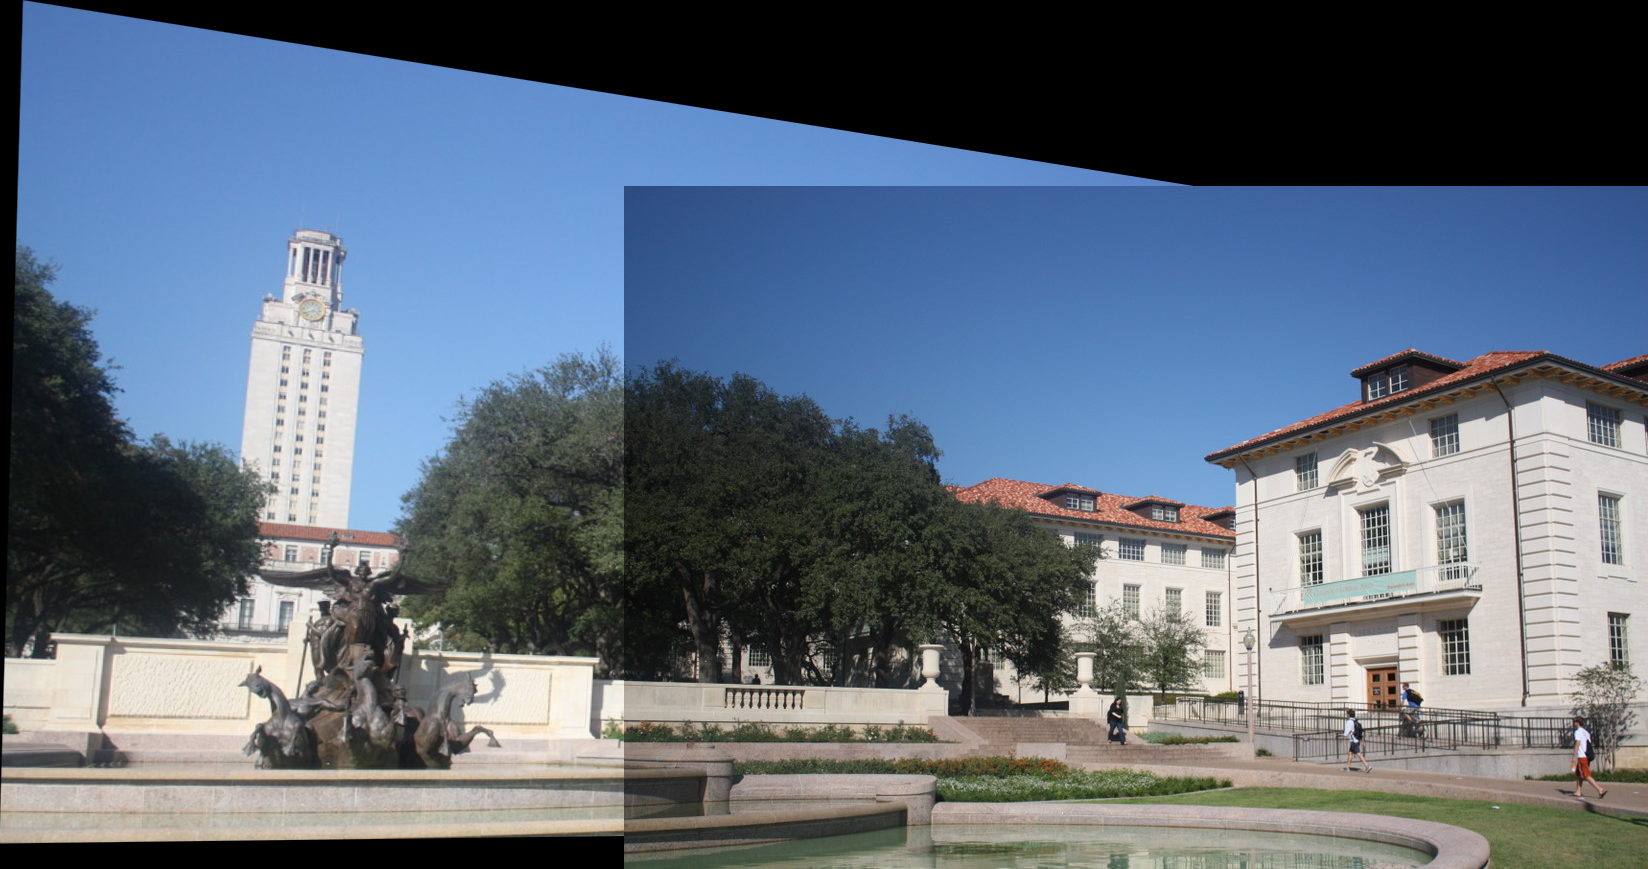

In [41]:
import sys

im1 = cv2.imread("uttower_left.jpg")
im2 = cv2.imread("uttower_right.jpg")

im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

cv2_imshow(im1_gray)
cv2_imshow(im2_gray)

#define a detector to detect keypoints and descriptors
model = cv2.ORB_create(nfeatures=2000)

#find keypoints and descriptors using the detector
kps1, des1 = model.detectAndCompute(im1, None)
kps2, des2 = model.detectAndCompute(im2, None)


cv2_imshow (cv2.drawKeypoints(im2, kps2, None, (255, 0, 255)))

#creat a bfmatcher object that will match the features found
matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING)

#find matching points
matches = matcher.knnMatch(des1, des2,k=2)


def draw_matches(im1, kps1, im2, kps2, matches):
  r, c = im1.shape[:2]
  r1, c1 = im2.shape[:2]
  output = np.zeros((max([r, r1]), c+c1, 3), dtype='uint8')
  output[:r, :c, :] = np.dstack([im1, im1, im1])
  output[:r1, c:c+c1, :] = np.dstack([im2, im2, im2])

  #extracting matches
  for match in matches:
    im1_idx = match.queryIdx
    im2_idx = match.trainIdx
    (x1, y1) = kps1[im1_idx].pt
    (x2, y2) = kps2[im2_idx].pt

    #draw circles on the keypoints
    cv2.circle(output, (int(x1),int(y1)), 4, (0, 255, 255), 1)
    cv2.circle(output, (int(x2)+c,int(y2)), 4, (0, 255, 255), 1)

    #connect the keypoints
    cv2.line(output, (int(x1),int(y1)), (int(x2)+c,int(y2)), (0, 255, 255), 1)
    
  return output

all_matches = []
for m, n in matches:
  all_matches.append(m)

im3 = draw_matches(im1_gray, kps1, im2_gray, kps2, all_matches[:30])
cv2_imshow(im3)

#finding best matches
best = []
for m, n in matches:
    if m.distance < 0.6 * n.distance:
        best.append(m)

def warp(im1, im2, H):

  rows1, cols1 = im1.shape[:2]
  rows2, cols2 = im2.shape[:2]

  points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
  temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

  #after we have established a homography we need to warp perspective
  #changing field of view 
  print(temp_points)
  points_2 = cv2.perspectiveTransform(temp_points, H)

  points_final = np.concatenate((points_1,points_2), axis=0)

  [min_x, min_y] = np.int32(points_final.min(axis=0).ravel() - 0.5)
  [max_x, max_y] = np.int32(points_final.max(axis=0).ravel() + 0.5)
  
  trans_dist = [-min_x,-min_y]
  
  H_trans = np.array([[1, 0, trans_dist[0]], [0, 1, trans_dist[1]], [0, 0, 1]])

  output = cv2.warpPerspective(im2, H_trans.dot(H), (max_x-min_x, max_y-min_y))
  output[trans_dist[1]:rows1+trans_dist[1], trans_dist[0]:cols1+trans_dist[0]] = im1

  return output

MIN_MATCH_COUNT = 10

if len(best) > MIN_MATCH_COUNT:
    #convert keypoints to an argument for findHomography
    source = np.float32([ kps1[m.queryIdx].pt for m in best]).reshape(-1,1,2)
    target = np.float32([ kps2[m.trainIdx].pt for m in best]).reshape(-1,1,2)

    #getting a homography 
    M, _ = cv2.findHomography(source, target, cv2.RANSAC,5.0)
    
    print(M)
    result = warp(im2, im1, M)

    cv2_imshow(result)

####I wasn't able to complete the program using custom built functions, since I couldn't figure out how I was supposed to change the field of view. ALthough I did try to implement it using inbuilt functions and it worked fairly correctly. 